# **PROYEK KLASIFIKASI GAMBAR - INTEL IMAGE CLASSIFICATION**

## 1. Persiapan dan Konfigurasi Awal


In [ ]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import datetime
import zipfile
import random
import shutil

Bagian ini mengimpor semua pustaka yang diperlukan untuk proyek klasifikasi gambar. Library utama yang digunakan adalah TensorFlow/Keras untuk deep learning, NumPy untuk manipulasi array, Matplotlib dan Seaborn untuk visualisasi, PIL untuk manipulasi gambar, dan Scikit-learn untuk metrik evaluasi. Selain itu, kode membuat direktori untuk menyimpan model dalam berbagai format (model ekspor standar, format mobile, dan format web).

## 2. Ekstraksi dan Persiapan Dataset

### 2.1 Ekstraksi Dataset


In [11]:
import os
import zipfile
import shutil
from sklearn.model_selection import train_test_split

# Check and extract dataset if needed
if os.path.exists('intel_image_dataset.zip') and not os.path.exists('intel_dataset'):
    print("Extracting intel_image_dataset.zip...")
    with zipfile.ZipFile('intel_image_dataset.zip', 'r') as zip_ref:
        zip_ref.extractall('.')
    print("Dataset extracted successfully.")
elif os.path.exists('intel_dataset'):
    print("Dataset already extracted.")
else:
    print("intel_image_dataset.zip not found. Please make sure the file is in the current directory.")

Extracting intel_image_dataset.zip...
Dataset extracted successfully.


Kode ini memeriksa apakah dataset sudah diekstrak. Jika belum, dan file zip ada, maka akan mengekstrak file zip. Dataset Intel Image Classification berisi gambar-gambar pemandangan natural yang dikategorikan. Setelah ekstraksi, kode ini menetapkan jalur direktori untuk data train, test, dan validation yang asli.

### 2.2 Pembuatan Struktur Dataset Kustom

In [12]:
# Determine the actual directory structure
if os.path.exists('seg_train') and os.path.isdir('seg_train'):
    seg_train_dir = 'seg_train'
    seg_test_dir = 'seg_test'
    seg_pred_dir = 'seg_pred'
    print("Menggunakan direktori dataset di root folder")
elif os.path.exists('intel_dataset/seg_train') and os.path.isdir('intel_dataset/seg_train'):
    seg_train_dir = 'intel_dataset/seg_train'
    seg_test_dir = 'intel_dataset/seg_test'
    seg_pred_dir = 'intel_dataset/seg_pred'
    print("Menggunakan direktori dataset di dalam folder intel_dataset")
else:
    print("Dataset tidak ditemukan di lokasi yang diharapkan")
    raise FileNotFoundError("Dataset tidak ditemukan. Pastikan direktori seg_train, seg_test, dan seg_pred tersedia.")

# Create a custom dataset split structure
custom_dataset_dir = 'intel_dataset_split'
custom_train_dir = os.path.join(custom_dataset_dir, 'training')
custom_val_dir = os.path.join(custom_dataset_dir, 'validation')
custom_test_dir = os.path.join(custom_dataset_dir, 'testing')

# Remove existing split directory if it exists
if os.path.exists(custom_dataset_dir):
    shutil.rmtree(custom_dataset_dir)

# Create new directories
os.makedirs(custom_train_dir, exist_ok=True)
os.makedirs(custom_val_dir, exist_ok=True)
os.makedirs(custom_test_dir, exist_ok=True)

Menggunakan direktori dataset di root folder


Bagian ini membuat struktur direktori baru untuk menyimpan dataset yang akan dibagi secara kustom. Struktur ini memiliki tiga direktori utama: training, validation, dan testing. Jika direktori ini sudah ada, kode akan menghapusnya terlebih dahulu untuk memastikan dataset yang bersih.

### 2.3 Identifikasi Kategori Dataset


In [13]:
# Get all unique categories from the dataset
all_categories = set()
for category in os.listdir(seg_train_dir):
    if os.path.isdir(os.path.join(seg_train_dir, category)):
        all_categories.add(category)

for category in os.listdir(seg_test_dir):
    if os.path.isdir(os.path.join(seg_test_dir, category)):
        all_categories.add(category)

print(f"Total number of scene categories: {len(all_categories)}")

# Find categories present in both training and test sets
common_categories = []
for category in all_categories:
    train_cat_path = os.path.join(seg_train_dir, category)
    test_cat_path = os.path.join(seg_test_dir, category)

    if os.path.isdir(train_cat_path) and os.path.isdir(test_cat_path):
        common_categories.append(category)

print(f"Number of common categories: {len(common_categories)}")

Total number of scene categories: 8
Number of common categories: 6


Kode ini mengidentifikasi semua kategori (kelas) unik dalam dataset dan mencetak jumlah totalnya. Kemudian menemukan kategori yang ada di kedua set data (training dan testing) untuk memastikan konsistensi dalam pemrosesan selanjutnya.

### 2.4 Pengumpulan Jalur Gambar dan Pembagian Dataset


In [14]:
# Function to gather image paths for a category
def gather_image_paths(category):
    image_paths = []

    # Get images from training directory
    train_cat_path = os.path.join(seg_train_dir, category)
    if os.path.isdir(train_cat_path):
        for img_name in os.listdir(train_cat_path):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(train_cat_path, img_name)
                image_paths.append(img_path)
    
    # Get images from test directory
    test_cat_path = os.path.join(seg_test_dir, category)
    if os.path.isdir(test_cat_path):
        for img_name in os.listdir(test_cat_path):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(test_cat_path, img_name)
                image_paths.append(img_path)

    # Get images from validation directory if it exists
    val_cat_path = os.path.join(seg_pred_dir, category)
    if os.path.exists(val_cat_path) and os.path.isdir(val_cat_path):
        for img_name in os.listdir(val_cat_path):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(val_cat_path, img_name)
                image_paths.append(img_path)

    return image_paths

# Create custom train/validation/test split for each category
print("Creating custom train/validation/test split...")
for category in common_categories:
    # Create category directories in each split
    os.makedirs(os.path.join(custom_train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(custom_val_dir, category), exist_ok=True)
    os.makedirs(os.path.join(custom_test_dir, category), exist_ok=True)

    # Get all image paths for this category
    all_images = gather_image_paths(category)

    # Split into train and temp (validation + test)
    train_images, temp_images = train_test_split(all_images, test_size=0.3, random_state=42)

    # Split temp into validation and test
    val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

    # Copy images to their respective directories
    for img_path in train_images:
        img_name = os.path.basename(img_path)
        shutil.copy(img_path, os.path.join(custom_train_dir, category, img_name))

    for img_path in val_images:
        img_name = os.path.basename(img_path)
        shutil.copy(img_path, os.path.join(custom_val_dir, category, img_name))

    for img_path in test_images:
        img_name = os.path.basename(img_path)
        shutil.copy(img_path, os.path.join(custom_test_dir, category, img_name))

Creating custom train/validation/test split...


Fungsi gather_image_paths mengumpulkan semua jalur gambar untuk kategori tertentu dari direktori training, testing, dan validation asli. Kemudian, kode ini membuat pembagian kustom dataset dengan rasio 70% untuk training, 15% untuk validation, dan 15% untuk testing untuk setiap kategori. Gambar-gambar kemudian disalin ke direktori kustom yang sesuai.

### 2.5 Penghitungan dan Pembaruan Jalur Dataset

In [15]:
# Hitung jumlah gambar di masing-masing folder
train_count = sum([len(files) for _, _, files in os.walk(custom_train_dir)])
val_count = sum([len(files) for _, _, files in os.walk(custom_val_dir)])
test_count = sum([len(files) for _, _, files in os.walk(custom_test_dir)])
total_count = train_count + val_count + test_count

print(f"\nCustom dataset split completed:")
print(f"Training images: {train_count} ({train_count/total_count:.1%})")
print(f"Validation images: {val_count} ({val_count/total_count:.1%})")
print(f"Testing images: {test_count} ({test_count/total_count:.1%})")
print(f"Total images: {total_count}")

# Update path data untuk model
train_dir = custom_train_dir
val_dir = custom_val_dir
test_dir = custom_test_dir
print("\nData berhasil dipindahkan!")


Custom dataset split completed:
Training images: 11920 (70.0%)
Validation images: 2556 (15.0%)
Testing images: 2558 (15.0%)
Total images: 17034

Data berhasil dipindahkan!


Setelah pembagian selesai, kode menghitung jumlah gambar di setiap set (training, validation, testing) dan menampilkan hasilnya. Jalur direktori kemudian diperbarui untuk merujuk ke struktur dataset kustom yang baru dibuat untuk digunakan di bagian selanjutnya.

## 3. Eksplorasi dan Visualisasi Data


### 3.1 Memuat dan Menampilkan Sampel Gambar

Memeriksa struktur direktori training: intel_dataset_split\training
Kategori yang ditemukan: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Loading training images...
Memproses kategori: buildings, path: intel_dataset_split\training\buildings
  - Jumlah gambar ditemukan: 1839
Memproses kategori: forest, path: intel_dataset_split\training\forest
  - Jumlah gambar ditemukan: 1921
Memproses kategori: glacier, path: intel_dataset_split\training\glacier
  - Jumlah gambar ditemukan: 2069
Memproses kategori: mountain, path: intel_dataset_split\training\mountain
  - Jumlah gambar ditemukan: 2125
Memproses kategori: sea, path: intel_dataset_split\training\sea
  - Jumlah gambar ditemukan: 1948
Memproses kategori: street, path: intel_dataset_split\training\street
  - Jumlah gambar ditemukan: 2018
Membuka gambar: intel_dataset_split\training\sea\23165.jpg
Membuka gambar: intel_dataset_split\training\sea\8473.jpg
Membuka gambar: intel_dataset_split\training\sea\4088.jpg
Membuka gam

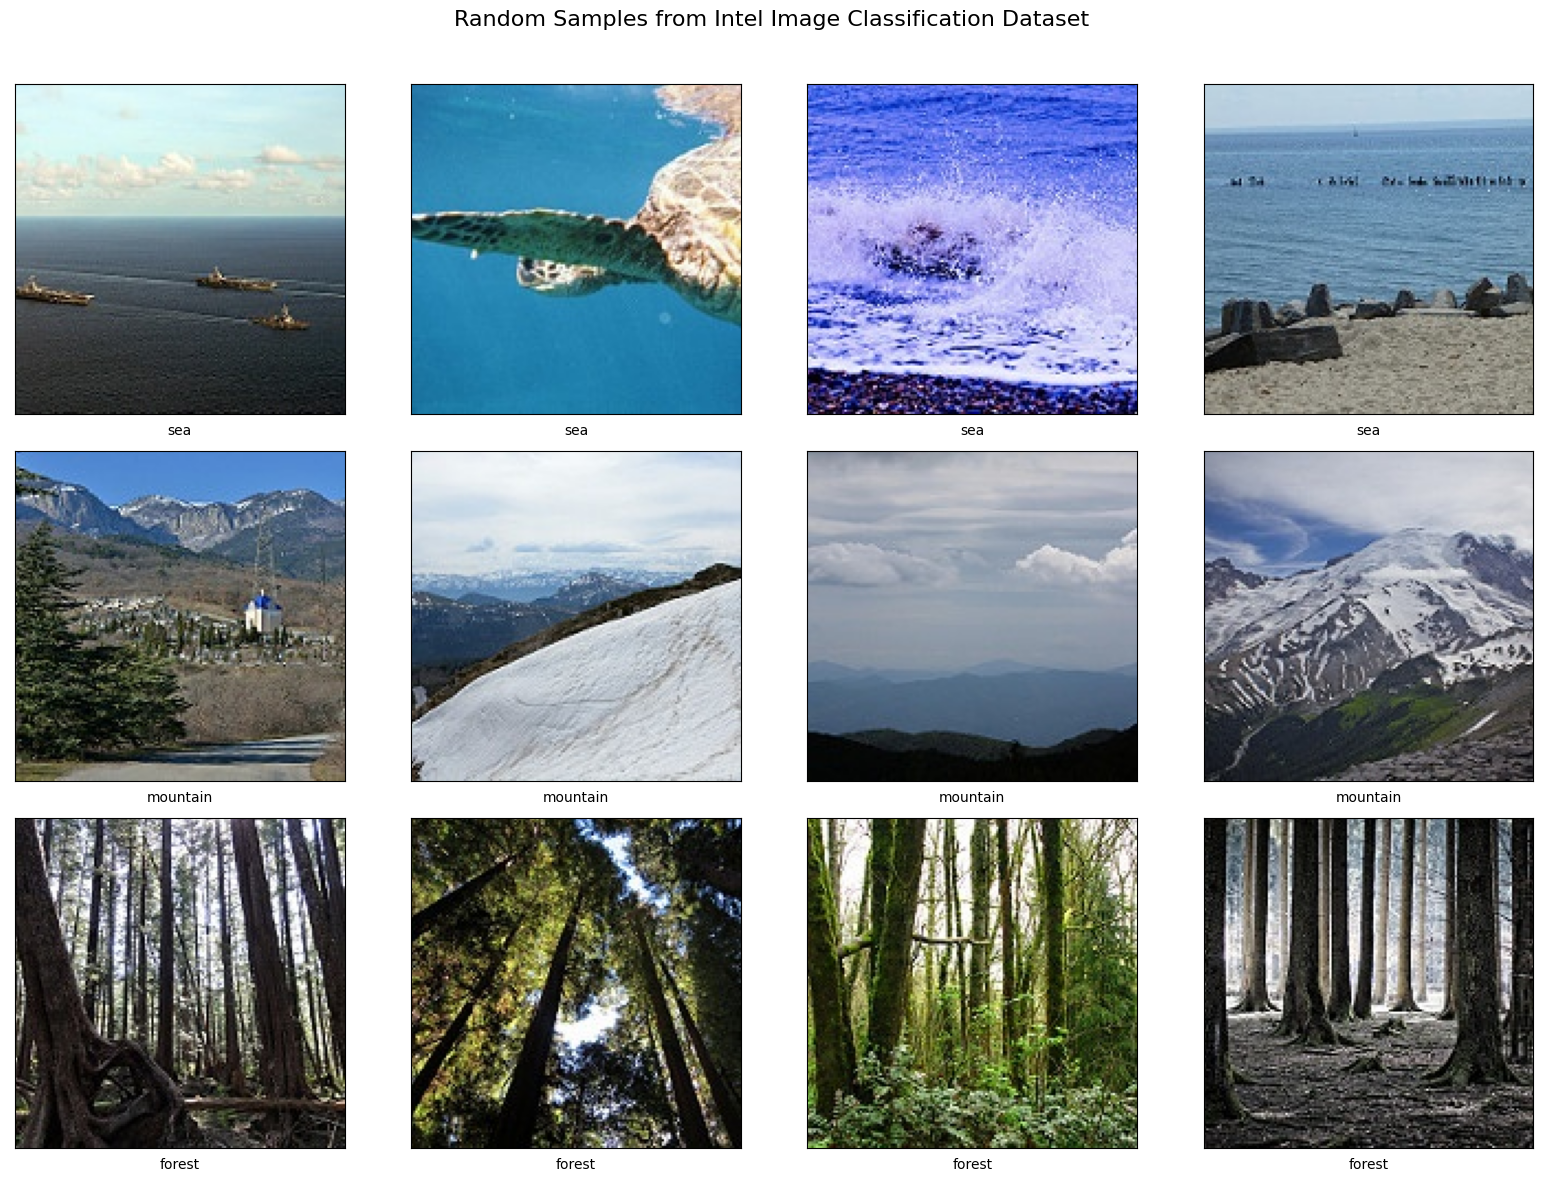

In [16]:
# Load and display sample images
category_images = {}

# Periksa struktur direktori terlebih dahulu
print(f"Memeriksa struktur direktori training: {train_dir}")
categories_in_train = []
for item in os.listdir(train_dir):
    item_path = os.path.join(train_dir, item)
    if os.path.isdir(item_path):
        categories_in_train.append(item)
        
print(f"Kategori yang ditemukan: {categories_in_train}")

# Fill dictionary with images from custom training set
print("Loading training images...")
for category in categories_in_train:
    category_path = os.path.join(train_dir, category)
    # Verifikasi path dan jumlah gambar
    print(f"Memproses kategori: {category}, path: {category_path}")
    
    if os.path.isdir(category_path):
        try:
            image_files = [f for f in os.listdir(category_path) 
                          if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            print(f"  - Jumlah gambar ditemukan: {len(image_files)}")
            
            if image_files:  # Jika ada gambar
                category_images[category] = image_files
            else:
                print(f"  - Tidak ada file gambar di direktori")
        except PermissionError:
            print(f"  - Error: Tidak mendapat izin akses ke direktori {category_path}")
        except Exception as e:
            print(f"  - Error: {str(e)}")

# Check if any categories were found
if not category_images:
    print("Tidak ada kategori dengan gambar yang ditemukan. Tidak dapat melanjutkan visualisasi.")
else:
    # Display random samples
    num_categories_to_show = min(len(category_images), 3)
    random_categories = random.sample(list(category_images.keys()), num_categories_to_show)

    fig, axs = plt.subplots(num_categories_to_show, 4, figsize=(16, 4*num_categories_to_show))
    fig.suptitle('Random Samples from Intel Image Classification Dataset', fontsize=16)

    for i, category in enumerate(random_categories):
        # Make sure the category has at least 4 images
        num_images = min(4, len(category_images[category]))
        images = np.random.choice(category_images[category], num_images, replace=False)

        for j, image_name in enumerate(images):
            img_path = os.path.join(train_dir, category, image_name)
            try:
                print(f"Membuka gambar: {img_path}")
                img = Image.open(img_path)
                axs[i, j].imshow(img)
                axs[i, j].set(xlabel=category, xticks=[], yticks=[])
            except Exception as e:
                print(f"Error membuka gambar {img_path}: {str(e)}")
                axs[i, j].text(0.5, 0.5, f"Error: {type(e).__name__}",
                              ha='center', va='center', transform=axs[i, j].transAxes)

    fig.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for suptitle
    plt.show()

Kode ini memuat semua gambar training ke dalam kamus, kemudian memilih 3 kategori secara acak dan menampilkan 4 gambar dari setiap kategori dalam sebuah grid. Ini memberikan gambaran visual tentang jenis gambar dalam dataset.

### 3.2 Visualisasi Distribusi Gambar Per Kategori


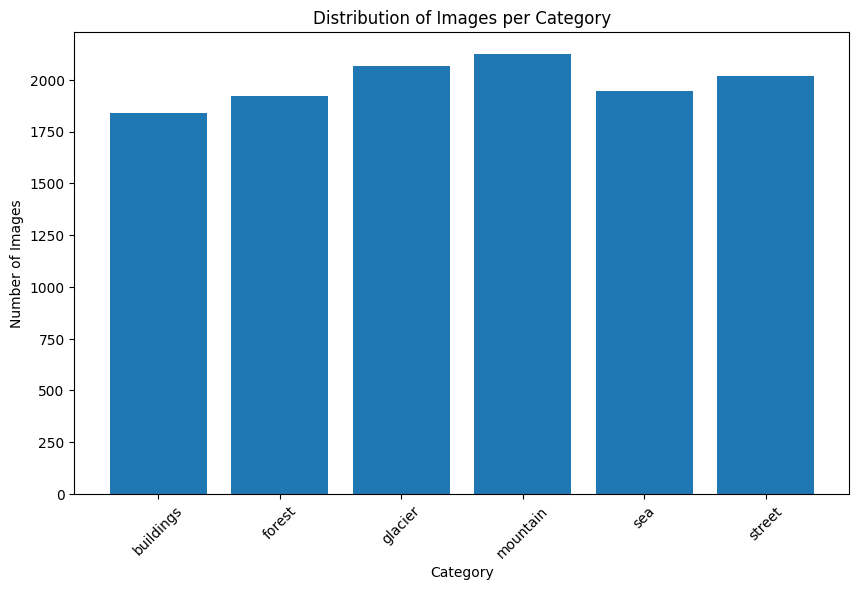

In [17]:
# Calculate number of images per category
category_counts = {}
for category in os.listdir(train_dir):
    category_path = os.path.join(train_dir, category)
    if os.path.isdir(category_path):
        category_counts[category] = len(os.listdir(category_path))

# Display distribution of images per category
plt.figure(figsize=(10, 6))
plt.bar(category_counts.keys(), category_counts.values())
plt.title('Distribution of Images per Category')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

Bagian ini menghitung jumlah gambar untuk setiap kategori dalam set training dan menampilkan distribusinya dalam bentuk diagram batang. Ini membantu untuk melihat apakah dataset seimbang atau tidak.

### 3.3 Memeriksa Dimensi Gambar


In [18]:
# Check image dimensions
random_category = random.choice(list(category_images.keys()))
random_image = random.choice(category_images[random_category])
img_path = os.path.join(train_dir, random_category, random_image)
img = Image.open(img_path)
print(f"\nSample image dimensions: {img.size}")
print(f"Sample image format: {img.format}")
print(f"Sample image mode: {img.mode}")


Sample image dimensions: (150, 150)
Sample image format: JPEG
Sample image mode: RGB


Kode ini memilih sebuah gambar secara acak dan mencetak dimensi, format, dan mode gambar. Informasi ini penting untuk memahami karakteristik input yang akan diproses oleh model.

## 4. Persiapan Data untuk Training


In [19]:
# Set up image dimensions and batch size
img_width, img_height = 150, 150
batch_size = 32

# Data generator for training with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Data generator for validation and testing without augmentation
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Get class indices and names
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())
print(f"Number of classes used in model: {len(class_names)}")

Found 11920 images belonging to 6 classes.
Found 2556 images belonging to 6 classes.
Found 2558 images belonging to 6 classes.
Number of classes used in model: 6


Bagian ini menyiapkan data untuk training model. Pertama, menetapkan dimensi gambar (150x150 piksel) dan ukuran batch (32). Kemudian membuat data generator untuk:

1. Training data dengan augmentasi (rotasi, shift, zoom, flip) untuk meningkatkan variasi data
2. Validation dan testing data tanpa augmentasi

Data generator membaca gambar langsung dari direktori dan mengubahnya menjadi format yang siap untuk training. Kode juga mendapatkan indeks kelas dan nama kelas yang akan digunakan dalam model.

## 5. Definisi dan Pembuatan Model


In [20]:
# Define model architecture
def create_scene_classifier(input_shape=(img_width, img_height, 3), num_classes=len(class_names)):
    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Second Convolutional Block
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Third Convolutional Block
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Fourth Convolutional Block
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Flatten layer
        Flatten(),

        # Dense layers
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create model
scene_classifier = create_scene_classifier()
scene_classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 150, 150, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                        

Kode ini mendefinisikan arsitektur model Convolutional Neural Network (CNN) untuk klasifikasi gambar scene. Model terdiri dari:

1. Empat blok konvolusional, masing-masing dengan Conv2D, BatchNormalization, dan Dropout
2. Jumlah filter yang meningkat dari 32 hingga 256
3. Layer Flatten untuk mengubah data konvolusional menjadi vektor 1D
4. Dense layer dengan 512 neuron dan layer output dengan jumlah neuron yang sama dengan jumlah kelas

Model dikompilasi dengan optimizer Adam, fungsi loss categorical_crossentropy, dan metrik akurasi. Akhirnya, ringkasan model ditampilkan untuk melihat arsitektur lengkap dan jumlah parameter yang dapat dilatih.

## 6. Callback dan Training Model


### 6.1 Definisi Callback


In [21]:
# Custom callback to stop training when accuracy reaches target level
class TargetAccuracyCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold=0.95):
        super(TargetAccuracyCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')

        if accuracy is not None and accuracy > self.threshold and val_accuracy > 0.90:
            print(f'\nReached {self.threshold*100}% training accuracy and 90% validation accuracy. Stopping training.')
            self.model.stop_training = True

# Create directories for logs and checkpoints
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs(log_dir, exist_ok=True)
os.makedirs('saved_checkpoints', exist_ok=True)

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='saved_checkpoints/best_scene_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    TensorBoard(
        log_dir=log_dir,
        histogram_freq=1
    ),
    # Add custom callback to stop at high accuracy
    TargetAccuracyCallback(threshold=0.95)
]

Bagian ini mendefinisikan berbagai callback yang akan digunakan selama training:

1. TargetAccuracyCallback - Callback kustom untuk menghentikan training ketika akurasi mencapai threshold tertentu (95% untuk training dan 90% untuk validation)
2. EarlyStopping - Menghentikan training jika tidak ada peningkatan dalam validation loss selama 10 epoch
3. ModelCheckpoint - Menyimpan model terbaik berdasarkan validation accuracy
4. ReduceLROnPlateau - Mengurangi learning rate jika validation loss tidak membaik selama 5 epoch
5. TensorBoard - Untuk logging dan visualisasi metrik training

### 6.2 Training Model


In [22]:
epochs = 50

# Train the model
history = scene_classifier.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=callbacks,
    verbose=1
)

# Load best model if available
if os.path.exists('saved_checkpoints/best_scene_model.h5'):
    scene_classifier = tf.keras.models.load_model('saved_checkpoints/best_scene_model.h5')
    print("Loaded best model from checkpoints.")

Epoch 1/50
372/372 [==============================] - ETA: 0s - loss: 1.3049 - accuracy: 0.5508
Epoch 1: val_accuracy improved from -inf to 0.28600, saving model to saved_checkpoints\best_scene_model.h5
372/372 [==============================] - 988s 3s/step - loss: 1.3049 - accuracy: 0.5508 - val_loss: 2.7648 - val_accuracy: 0.2860 - lr: 0.0010
Epoch 2/50
372/372 [==============================] - ETA: 0s - loss: 0.8986 - accuracy: 0.6711
Epoch 2: val_accuracy improved from 0.28600 to 0.72191, saving model to saved_checkpoints\best_scene_model.h5
372/372 [==============================] - 958s 3s/step - loss: 0.8986 - accuracy: 0.6711 - val_loss: 0.8258 - val_accuracy: 0.7219 - lr: 0.0010
Epoch 3/50
372/372 [==============================] - ETA: 0s - loss: 0.7866 - accuracy: 0.7116
Epoch 3: val_accuracy did not improve from 0.72191
372/372 [==============================] - 928s 2s/step - loss: 0.7866 - accuracy: 0.7116 - val_loss: 1.5790 - val_accuracy: 0.4960 - lr: 0.0010
Epoch 4/5

Kode ini melakukan training model dengan parameter:

1. Train generator sebagai sumber data training
2. 50 epoch maksimal (meskipun early stopping mungkin mengakhirinya lebih awal)
3. Validation data untuk evaluasi selama training
4. Callback yang didefinisikan sebelumnya

Setelah training, kode mencoba untuk memuat model terbaik dari checkpoint yang disimpan (jika ada) untuk memastikan bahwa model terbaik digunakan untuk evaluasi.

## 7. Evaluasi Model


### 7.1 Evaluasi pada Training dan Test Data


In [23]:
# Evaluate model on training data
train_loss, train_acc = scene_classifier.evaluate(train_generator, verbose=1)

# Evaluate model on test data
test_loss, test_acc = scene_classifier.evaluate(test_generator, verbose=1)

# Print all accuracies for comparison
print("\nAccuracy Comparison:")
print(f'Training accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)')
print(f'Validation accuracy: {history.history["val_accuracy"][-1]:.4f} ({history.history["val_accuracy"][-1]*100:.2f}%)')
print(f'Test accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)')

print("\nLoss Comparison:")
print(f'Training loss: {train_loss:.4f}')
print(f'Validation loss: {history.history["val_loss"][-1]:.4f}')
print(f'Test loss: {test_loss:.4f}')

80/80 [==============================] - 56s 705ms/step - loss: 0.2635 - accuracy: 0.9116

Accuracy Comparison:
Training accuracy: 0.9389 (93.89%)
Validation accuracy: 0.9157 (91.57%)
Test accuracy: 0.9116 (91.16%)

Loss Comparison:
Training loss: 0.1781
Validation loss: 0.2558
Test loss: 0.2635


Bagian ini mengevaluasi model pada data training dan testing, lalu mencetak perbandingan akurasi dan loss untuk training, validation, dan testing. Perbandingan ini membantu untuk melihat apakah model overfit (akurasi training jauh lebih tinggi dari testing) atau underfit.

### 7.2 Visualisasi History Training


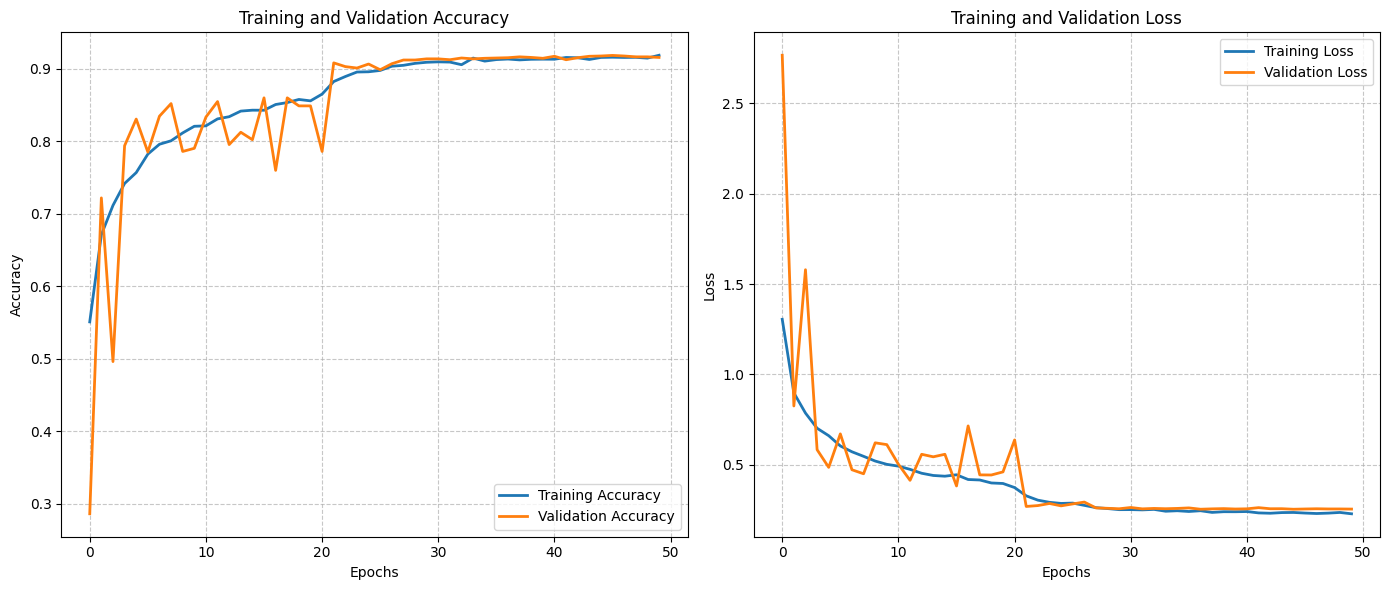

In [24]:
def visualize_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', linewidth=2)
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', linewidth=2)
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', linewidth=2)
    plt.plot(epochs_range, val_loss, label='Validation Loss', linewidth=2)
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

visualize_training_history(history)

Fungsi ini memvisualisasikan history training dengan dua plot: satu untuk akurasi dan satu untuk loss. Masing-masing plot menampilkan metrik training dan validation selama proses training. Ini membantu untuk melihat bagaimana model belajar dari waktu ke waktu dan kapan mulai terjadi overfitting (jika validation loss mulai meningkat sementara training loss terus menurun).

### 7.3 Confusion Matrix dan Classification Report


80/80 [==============================] - 41s 503ms/step


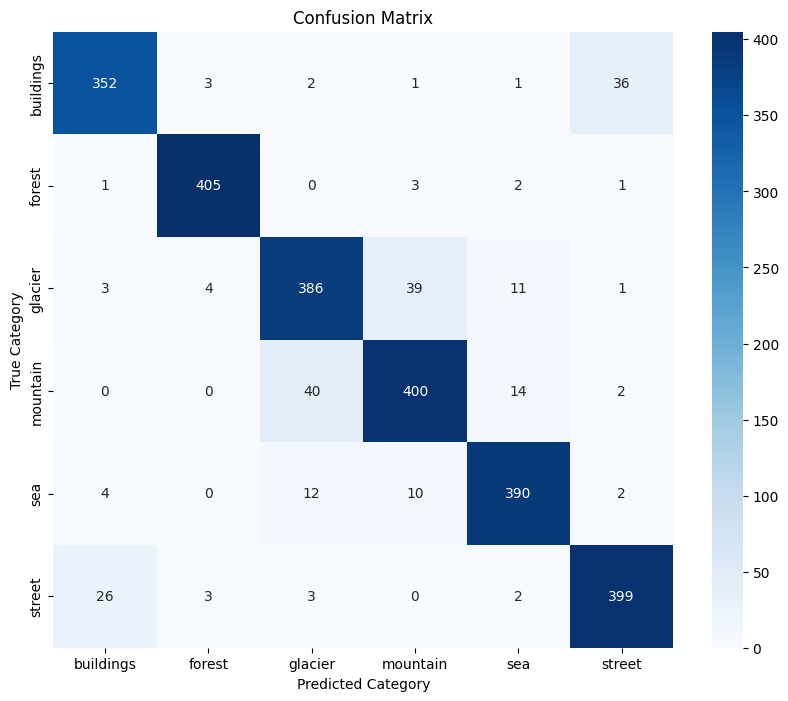

Classification Report:
              precision    recall  f1-score   support

   buildings       0.91      0.89      0.90       395
      forest       0.98      0.98      0.98       412
     glacier       0.87      0.87      0.87       444
    mountain       0.88      0.88      0.88       456
         sea       0.93      0.93      0.93       418
      street       0.90      0.92      0.91       433

    accuracy                           0.91      2558
   macro avg       0.91      0.91      0.91      2558
weighted avg       0.91      0.91      0.91      2558



In [25]:
# Get predictions for confusion matrix
test_generator.reset()
steps = int(np.ceil(test_generator.samples/batch_size))
predictions = scene_classifier.predict(test_generator, steps=steps)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes[:test_generator.samples], predicted_classes[:test_generator.samples])

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Category')
plt.ylabel('True Category')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(
    true_classes,
    predicted_classes,
    labels=range(len(class_names)),
    target_names=class_names
))

Kode ini membuat dan menampilkan confusion matrix dan classification report. Confusion matrix memvisualisasikan prediksi model versus nilai sebenarnya, membantu mengidentifikasi di mana model sering membuat kesalahan. Classification report memberikan metrik detil seperti precision, recall, dan F1-score untuk setiap kelas serta rata-rata keseluruhan.

## 8. Ekspor Model dalam Berbagai Format


In [30]:
# Create required directories
os.makedirs('saved_model', exist_ok=True)
os.makedirs('tflite', exist_ok=True)
os.makedirs('tfjs_model', exist_ok=True)

# 1. SavedModel format
try:
    # Try using model.export() (for Keras 3.x)
    scene_classifier.export(filepath='saved_model')
    print("Model exported in SavedModel format at 'saved_model'")
except AttributeError:
    # Fallback to tf.saved_model.save() (for TensorFlow 2.x)
    tf.saved_model.save(scene_classifier, 'saved_model')
    print("Model saved in SavedModel format at 'saved_model'")

# 2. .keras or .h5 format
try:
    # Try .keras format (for Keras 3.x)
    scene_classifier.save('scene_classifier.keras')
    print("Model saved in .keras format at 'scene_classifier.keras'")
except ValueError:
    # Fallback to .h5 format (for TensorFlow 2.x)
    scene_classifier.save('scene_classifier.h5')
    print("Model saved in .h5 format at 'scene_classifier.h5'")

# 3. TF-Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(scene_classifier)
tflite_model = converter.convert()
with open('tflite/scene_classifier.tflite', 'wb') as f:
    f.write(tflite_model)
print("Model saved in TF-Lite format at 'tflite/scene_classifier.tflite'")

# Save labels for TF-Lite
with open('tflite/labels.txt', 'w') as f:
    for class_name in class_names:
        f.write(f"{class_name}\n")
print("Labels saved for TF-Lite model at 'tflite/labels.txt'")

# 4. TFJS format
try:
    import tensorflowjs as tfjs
except ImportError:
    import subprocess
    subprocess.check_call(['pip', 'install', 'tensorflowjs==3.18.0'])
    import tensorflowjs as tfjs

# Convert model to TFJS format
try:
    tfjs.converters.save_keras_model(scene_classifier, 'tfjs_model')
    print("Model saved in TensorFlow.js format at 'tfjs_model'")
except Exception as e:
    print(f"Error converting to TFJS format: {str(e)}")

INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


Model saved in SavedModel format at 'saved_model'
Model saved in .keras format at 'scene_classifier.keras'


INFO:tensorflow:Assets written to: C:\Users\ACER\AppData\Local\Temp\tmpxsf0eyef\assets


INFO:tensorflow:Assets written to: C:\Users\ACER\AppData\Local\Temp\tmpxsf0eyef\assets


Model saved in TF-Lite format at 'tflite/scene_classifier.tflite'
Labels saved for TF-Lite model at 'tflite/labels.txt'
Model saved in TensorFlow.js format at 'tfjs_model'


Bagian ini menyimpan model dalam berbagai format untuk berbagai kebutuhan:

1. SavedModel - Format standar TensorFlow untuk deployment
2. .keras/.h5 - Format Keras standar yang kompatibel dengan banyak aplikasi
3. TF-Lite - Format ringan untuk deployment di perangkat mobile dan edge
4. TFJS - Format untuk digunakan di browser dengan TensorFlow.js

Kode ini juga menyimpan label kategori untuk model TF-Lite, yang diperlukan untuk menafsirkan output saat menggunakan model di aplikasi.

## 9. Uji Inferensi



Inference with current model:
1/1 [==============================] - 0s 252ms/step
Image: intel_dataset_split\testing\buildings\5563.jpg
True category: buildings
Predicted category: buildings
Confidence: 1.0000


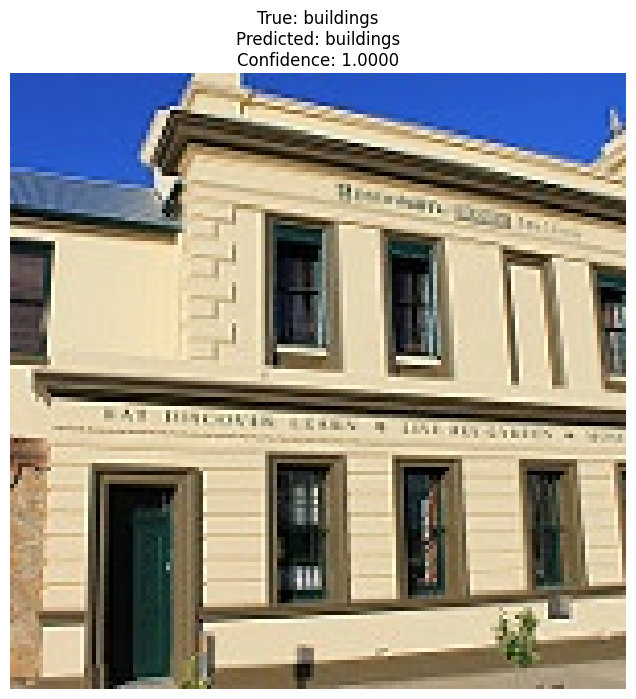


Inference with TF-Lite:
True category: buildings
Predicted category: buildings
Confidence: 0.9998


In [27]:
# Test inference with the model
def preprocess_image_for_prediction(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_width, img_height))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Find test images for inference
test_category_dirs = [os.path.join(test_dir, cls) for cls in class_names]
valid_category_dirs = [d for d in test_category_dirs if os.path.isdir(d) and len(os.listdir(d)) > 0]

if valid_category_dirs:
    random_category_dir = random.choice(valid_category_dirs)
    random_category = os.path.basename(random_category_dir)

    if os.listdir(random_category_dir):
        random_image = random.choice(os.listdir(random_category_dir))
        test_image_path = os.path.join(random_category_dir, random_image)

        # Prepare image for inference
        test_img = preprocess_image_for_prediction(test_image_path)

        # Inference using model in memory
        print(f"\nInference with current model:")
        predictions = scene_classifier.predict(test_img)
        predicted_class = np.argmax(predictions[0])
        predicted_class_name = class_names[predicted_class]

        print(f"Image: {test_image_path}")
        print(f"True category: {random_category}")
        print(f"Predicted category: {predicted_class_name}")
        print(f"Confidence: {predictions[0][predicted_class]:.4f}")

        # Visualize image with prediction
        plt.figure(figsize=(8, 8))
        img = tf.keras.preprocessing.image.load_img(test_image_path)
        plt.imshow(img)
        plt.title(f"True: {random_category}\nPredicted: {predicted_class_name}\nConfidence: {predictions[0][predicted_class]:.4f}")
        plt.axis('off')
        plt.show()

        # Test TF-Lite model
        try:
            interpreter = tf.lite.Interpreter(model_path='mobile_format/scene_classifier.tflite')
            interpreter.allocate_tensors()

            input_details = interpreter.get_input_details()
            output_details = interpreter.get_output_details()

            interpreter.set_tensor(input_details[0]['index'], test_img)
            interpreter.invoke()
            tflite_predictions = interpreter.get_tensor(output_details[0]['index'])
            tflite_predicted_class = np.argmax(tflite_predictions[0])
            tflite_predicted_class_name = class_names[tflite_predicted_class]

            print(f"\nInference with TF-Lite:")
            print(f"True category: {random_category}")
            print(f"Predicted category: {tflite_predicted_class_name}")
            print(f"Confidence: {tflite_predictions[0][tflite_predicted_class]:.4f}")
        except Exception as e:
            print(f"\nError with TF-Lite inference: {str(e)}")

Bagian akhir ini melakukan pengujian inferensi dengan model yang sudah dilatih:

1. Pertama, fungsi preprocess_image_for_prediction didefinisikan untuk memproses gambar input:

*   Memuat gambar dan mengubah ukurannya menjadi dimensi yang diharapkan (150x150)
*   Mengkonversi gambar ke array NumPy
*   Menskalakan nilai piksel ke rentang [0,1]
*   Menambahkan dimensi batch (karena model mengharapkan input batch)

2. Kemudian, kode memilih gambar secara acak dari set pengujian untuk diuji:

*   Memilih kategori acak dan gambar acak dari kategori tersebut
*   Memproses gambar untuk prediksi
*   Melakukan inferensi dengan model yang sudah dilatih
*   Menampilkan gambar bersama dengan label sebenarnya, prediksi, dan tingkat kepercayaan

3. Terakhir, kode menguji inferensi dengan model TF-Lite yang telah diekspor:

*   Memuat model TF-Lite dengan interpreter
*   Mengalokasikan tensor
*   Melakukan inferensi dan menampilkan hasil prediksi
*   Menangani kemungkinan error yang terjadi selama inferensi

Pengujian inferensi ini penting untuk memverifikasi bahwa model berperilaku seperti yang diharapkan ketika digunakan untuk memprediksi gambar baru dan bahwa model yang diekspor (seperti format TF-Lite untuk mobile) berfungsi dengan benar.

**Kesimpulan Keseluruhan Kode**

Kode ini mendemonstrasikan proses end-to-end untuk membangun dan mengevaluasi model klasifikasi gambar menggunakan TensorFlow/Keras:

1. **Persiapan Data:** Mengekstrak dataset, membuat pembagian kustom (train/validation/test), dan mengeksplorasi data.
2. **Preprocessing Data:** Menggunakan data augmentation untuk meningkatkan variasi dataset dan generator data Keras untuk memuat dan memproses data secara efisien.
3. **Arsitektur Model:** Membangun CNN dengan beberapa blok konvolusional yang masing-masing memiliki Conv2D, BatchNormalization, dan Dropout untuk menghindari overfitting.
4. **Training Model:** Menggunakan callback seperti EarlyStopping dan ReduceLROnPlateau untuk optimasi training, serta menyimpan model terbaik.
5. **Evaluasi Model:** Mengevaluasi performa dengan berbagai metrik dan visualisasi, termasuk confusion matrix dan classification report.
6. **Ekspor Model:** Menyimpan model dalam berbagai format untuk deployment di platform yang berbeda (server, mobile, web).
7. **Inferensi:** Menguji model dengan data baru untuk memastikan bahwa model berfungsi sebagaimana mestinya.

Keseluruhan, kode ini adalah contoh yang baik dari pipeline machine learning lengkap untuk masalah klasifikasi gambar, yang dapat digunakan sebagai template untuk proyek klasifikasi gambar lainnya.